## QBUS3850 Lab 6 (Combination)

The M-Competitions (Makridakis Competitions) are 'a series of open competitions organized and led by forecasting researcher Prof. Spyros Makridakis, intending to evaluate and compare the accuracy of different forecasting methods.'
https://mofc.unic.ac.cy/history-of-competitions/

The M4 dataset consists of '100,000 time series selected ... from industries, services, tourism, imports & exports, demographics, education, labor & wage, government, households, bonds, stocks, insurances, loans, real estate, transportation, and natural resources & environment'.
https://mofc.unic.ac.cy/the-dataset/

Further information and results (open access):
https://www.sciencedirect.com/science/article/pii/S0169207019301128


We will look at the monthly series:
 - There are 48,000 series. Each series provides a training set for algorithms to produce forecasts, and a test set against which the forecasts are evaluated.
 - The minimum length of the training set for each series is 42, although many series are much longer. 
 - The test set has length 18 for each series.

M4 codebase:
git clone https://github.com/Mcompetitions/M4-methods

(Requires .deb packages: libblas-dev, liblapack-dev, libcurl4-openssl-dev)
(Requires R packages: forecast)

In [1]:
import matplotlib.pyplot as plt
import statsmodels as sm 

import statsmodels.api as smt
import numpy as np
import pandas as pd
import warnings

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
## Load the train and test datasets.
df_train = pd.read_csv('Monthly-train.csv', index_col='V1' )
df_test = pd.read_csv('Monthly-test.csv', index_col='V1' )


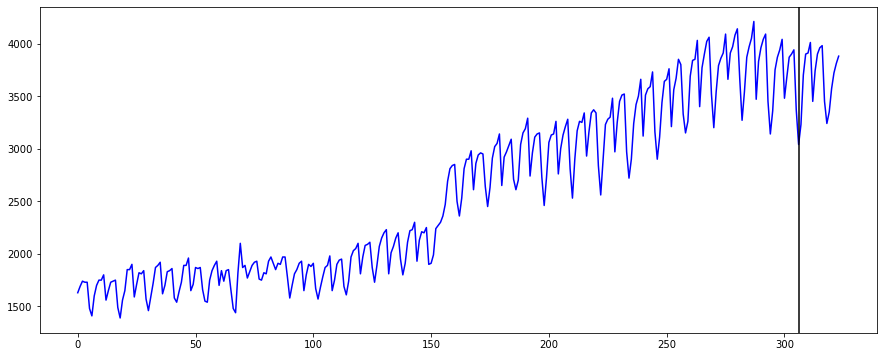

In [3]:
## Plot one of the timeseries.
i = 567
train = df_train.iloc[ i, ].dropna()
test = df_test.iloc[ i, ].dropna()

plt.figure()
plt.plot( np.r_[ train, test ], 'blue' )
plt.axvline( x=len(train), color='black' )

In [4]:
## Performance measure (from M4-methods/'Benchmarks and Evaluation.R')
## Symmetric Mean Absolute Percentage Error (sMAPE)
def smape( outsample, forecasts ):
    errors = 200 * np.abs( outsample - forecasts ) / ( np.abs( outsample ) + np.abs( forecasts ) )
    return np.mean( errors )

## Alternative performance measure:
## Root-Mean-Square Percentage Error (RMSPE)
def rmspe( outsample, forecasts ):
    errors = 100 * ( outsample - forecasts ) / outsample
    return np.sqrt( np.mean( np.square( errors ) ) )


In [5]:
## Test performance measures.
outsample = np.asarray( [ 100, 100, 100 ] )
forecasts = np.asarray( [ 105, 95, 95 ] )
print( smape( outsample, forecasts ) )
print( rmspe( outsample, forecasts ) )

5.044819678966021
5.0


### Decomposition
 - For seasonal adjustment, use statsmodels' in-built decomposition, or the method presented in Lab 2.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
horizon = 18
m = 12

decomposition = seasonal_decompose( train, period=m, model='mult' )
seasind = np.tile( decomposition.seasonal[-m:], 1 + horizon//m )[:horizon]
seasadj = train / decomposition.seasonal

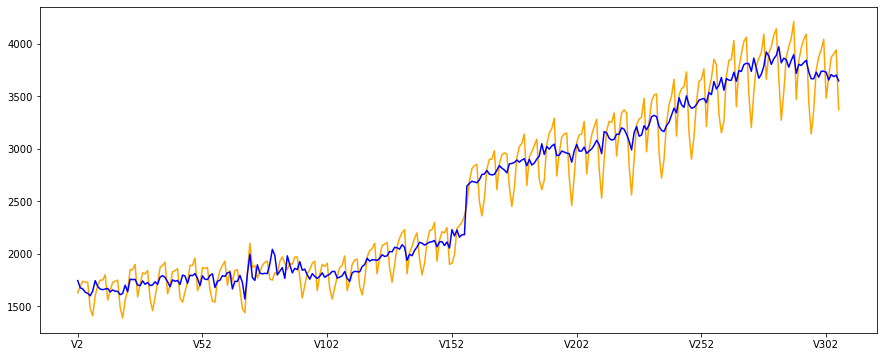

In [8]:
train.plot( color='orange')
seasadj.plot( color='blue')


## Task. 

### 1. Construct the following benchmark forecasting algorithms:
 - fc0. Naive random walk
 - fc1. Seasonal random walk
 - fc2. Seasonally adjusted random walk
 - fc3. Simple Exponential Smoothing of seasonally adjusted data
 - fc4. Holt Smoothing of seasonally adjusted data
 - fc5. Damped Holt Smoothing of seasonally adjusted data
  
### 2. Construct the combination forecast:
 - fc6 = ( fc3 + fc4 + fc5 )/3
and compare its performance to each individual benchmark.

### Benchmark forecasting algorithms

In [9]:
## Naive random walk:
def naive_rw( train ):
    return [ train[-1] ] * horizon

## Seasonal random walk:
def seasonal_rw( train ):
    return np.tile( train[-m:], 1 + horizon//m )[:horizon]

## Simple exponential smoothing:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
def ses( train ):
    fit = SimpleExpSmoothing( train.values ).fit()
    return np.asarray( fit.forecast( horizon ) )

## Holt-Winters:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
def holt( train ):
    fit = ExponentialSmoothing( train.values, trend="mul", damped=False, freq=None ).fit()
    return np.asarray( fit.forecast( horizon ) )

## Damped:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
def damped( train ):
    fit = ExponentialSmoothing( train.values, trend="mul", damped=True, freq=None ).fit()
    return np.asarray( fit.forecast( horizon ) )


c:\program files\python38\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
c:\program files\python38\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
c:\program files\python38\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


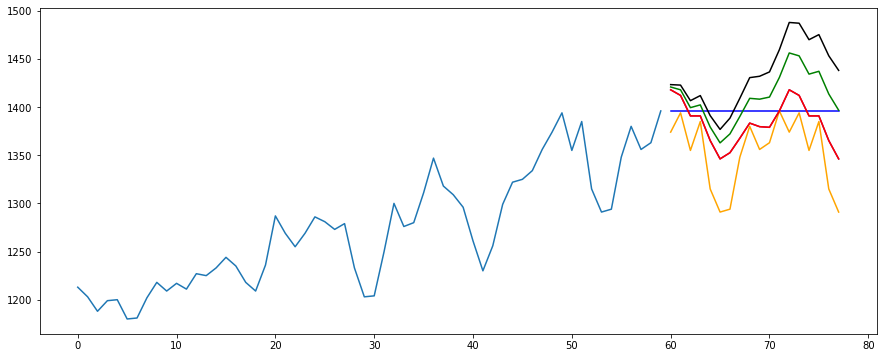

In [13]:
## Test benchmarks
i = 222
train = df_train.iloc[ i, ].dropna()

decomposition = seasonal_decompose( train, period=m, model='mult' )
seasind = np.tile( decomposition.seasonal[-m:], 1 + horizon//m )[:horizon]
seasadj = train / decomposition.seasonal

tail = 60
plt.plot( train.values[-tail:] )

def show( forecasts, color ):
    plt.plot( np.r_[ [np.NaN]*tail, forecasts ], color=color )
    #print( forecasts )
    
show( naive_rw( train ), 'blue' )
show( seasonal_rw( train ), 'orange' )
show( naive_rw( seasadj ) * seasind, 'purple' )
show( ses( seasadj ) * seasind, 'red' )
show( holt( seasadj ) * seasind, 'green' )
show( damped( seasadj ) * seasind, 'black' )


### Evaluate benchmark algorithms' performance

In [11]:
assert( len( df_train ) == len( df_test ) )

m = 12 ## Seasonality
horizon = 18 ## Forecasting horizon

colnames = [ 'naive_rw', 'seasonal_rw', 'seasadj_rw', 'ses', 'holt', 'damped', 'combination' ]
perf = pd.DataFrame( index=df_train.index, columns=colnames )

#for i in range( 0, len( df_train ) ) :
for i in range( 0, 800 ) :
    train = df_train.iloc[ i, ].dropna()
    test = df_test.iloc[ i, ].dropna()

    assert( len(test) == horizon )
    
    decomp = seasonal_decompose( train, period=m, model='mult' )
    seasadj = train / decomp.seasonal
    seasind = np.tile( decomp.seasonal[-m:], 1 + horizon//m )[:horizon]    
    
    fc0 = naive_rw( train )
    perf.iloc[i,0] = smape( test, fc0 )
       
    fc1 = seasonal_rw( train )
    perf.iloc[i,1] = smape( test, fc1 )
    
    fc2 = naive_rw( seasadj ) * seasind
    perf.iloc[i,2] = smape( test, fc2 )

    ## Catch convergence warnings from exponential smoothing routines.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        fc3 = ses( seasadj ) * seasind
        perf.iloc[i,3] = smape( test, fc3 )

        fc4 = holt( seasadj ) * seasind
        perf.iloc[i,4] = smape( test, fc4 )

        fc5 = damped( seasadj ) * seasind
        perf.iloc[i,5] = smape( test, fc5 )

    fc6 = ( fc3 + fc4 + fc5 ) / 3
    perf.iloc[i,6] = smape( test, fc6 )
    
    ## Print a simple progress bar. Each '#' represents 10 series; each line 1000 series.
    if i%10 == 9:
        print( '#', sep='', end='' )
    if i%1000 == 999:
        print()


################################################################################

In [12]:
print( "Performance by series:")
print( perf.head(20) )

print( "Performance overall:")
print( perf.mean().round(2) )


Performance by series:
     naive_rw seasonal_rw seasadj_rw       ses      holt    damped combination
V1                                                                            
M1    28.3703     15.4654    15.8568   15.4558   15.0331   15.4558       15.27
M2    33.6901     18.7877    22.4015   15.4753    14.131   15.4781     15.0312
M3     4.1986     5.17343    3.00135   3.26252  0.988524   1.24423     1.60492
M4    2.29766     3.54193      2.642     2.642   1.38365    2.6737     2.23547
M5    1.36187     2.16911    1.41253   1.26945   1.24347   1.49556     1.30332
M6    8.52851     13.6504    7.49467   7.49467   6.63612   5.23651     6.46129
M7    12.4122     21.5924    10.9711   10.9711   15.7413   5.87575     3.04181
M8    9.57973     18.7145    8.74367    8.8502   17.1673   4.84008     3.06259
M9    4.20276     4.02856    3.05713   3.05713   2.83023   3.16682      2.9714
M10   14.3714     20.5005    14.3168   14.3168   11.0881   14.2271     13.2267
M11   3.51141     1.12792    